In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import glob
import os
import nivapy3 as nivapy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib
from sqlalchemy import types
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Connect to db
ora_eng = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


# ICPW regional water chemistry assessment

**Note: This notebook requires Python 3, not Python 2.7.**

Kari has asked the ICPW focal centres to provide data for a wide range of sites (beyond the usual ICPW stations). She has only asked for a limited number of parameters (pH, ANC, ANCoaa and DOC) and for a single representative value per parameter and per site (e.g. a multi-year average). For now, the aim is to create maps showing each station coloured according to various classes (see e-mail from Kari received 07/02/2018 at 14.49 for class boundaries).

I've copied the raw Excel templates here:

C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Regional_Assessment_Maps\Data\Raw

The first step is to quality control them and then add them to a database for ease of access later. For the moment I'll just add them to Oracle under my own schema.

**Updated 10/04/2018**

Kari has additional data that she'd like to use. See e-mails received 05/04/2018 onwards for details.

**Updated 21/05/2018**

Kari has new datasets that she'd like to include. See e-mail received 16/05/2018 at 14.25 for details.

## 0. Co-ordinate conversion for Norway and US

UTM co-ordinates for the Norwegian stations need converting to WGS84.

In [3]:
## Read Norway data
#in_xlsx = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters'
#           r'\Regional_Assessment_Maps\Data\Raw_Final'
#           r'\Norway_Data template ICP W regional assessment July 2017 Norway v2.xlsx')
#nor_df = pd.read_excel(in_xlsx, sheetname='Sites UTM')
#
## Convert co-ords
#nor_df = nivapy.spatial.utm_to_wgs84_dd(nor_df, 
#                                        zone='UTM Zone',
#                                        east='UTM East',
#                                        north='UTM North')
#
## Write to CSV
#out_csv = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters'
#           r'\Regional_Assessment_Maps\Data\nor_wgs84.csv')
#nor_df.to_csv(out_csv, index=False, encoding='utf-8')
#
#nor_df.head()

I have imported this file back into the original Excel spreadsheet and then created a single "Sites" sheet with all the Norwegian co-ordinates in WGS84 decimal degrees.

For the USA, the longitudes in John's spreadsheet for alkes (*United States_lakes.U.S.regional.xlsx*) are missing a minus sign, which means all the lakes plot in Central Asia. I have corrected this in the Excel file *United States_lakes.U.S.regional.jes.xlsx*

## 1. Read and quality control data

**Note:** I have modified the Excel file names so that the country name can be extracted easily. This is useful later (see section 6).

In [3]:
# Get list of files to process
data_fold = (r'../Data/Raw_Final')
search_path = os.path.join(data_fold, '*.xlsx')
flist = glob.glob(search_path)

# Containers for data 
stn_df_list = []
val_df_list = []

for fpath in flist:
    # Get country
    country = os.path.split(fpath)[1].split('_')[0]
    
    # Read data
    stn_df = pd.read_excel(fpath, sheet_name='Sites')
    val_df = pd.read_excel(fpath, sheet_name='Data')

    # Add country
    stn_df['country'] = country
    val_df['country'] = country
    
    # Append to output
    stn_df_list.append(stn_df)
    val_df_list.append(val_df)
    
# Concatenate
stn_df = pd.concat(stn_df_list, axis=0)
val_df = pd.concat(val_df_list, axis=0)

# Get just cols of interest for vals table
val_df = val_df[['Site code', 'country', 'Parameter', 'Value']]
val_df.columns = ['stn_code', 'country', 'par_name', 'value']

# Tidy cols
stn_df.columns = ['stn_code', 'stn_name', 'icpw_stn_code', 
                  'eu_swb_code', 'eu_mon_code', 'wb_type', 
                  'latitude', 'longitude', 'altitude', 
                  'catch_area_km2', 'wb_area_km2', 'land_use',
                  'country']

# Make sure text col types are consistent
for col in stn_df.columns:
    if stn_df[col].dtypes == object:
        stn_df[col] = stn_df[col].astype(str)   

for col in val_df.columns:
    if val_df[col].dtypes == object:
        val_df[col] = val_df[col].astype(str)
        
# Checking
assert pd.notnull(stn_df['stn_code']).all(), 'Some station codes missing.'
assert pd.notnull(stn_df['latitude']).all(), 'Some latitudes missing.'
assert pd.notnull(stn_df['longitude']).all(), 'Some longitudes missing.'
print ('')
print ('The following station codes are used in the "Data" sheet, '
       'but not defined in the "Sites" sheet:')
print ('')
print (val_df[val_df['stn_code'].isin(set(val_df['stn_code']) - set(stn_df['stn_code']))])
print ('')
print ('The following station codes are used in the "Sites" sheet, '
       'but not in the "Data" sheet:')
print ('')
print (stn_df[stn_df['stn_code'].isin(set(stn_df['stn_code']) - 
                                     set(val_df['stn_code']))][['stn_code', 
                                                                'stn_name', 
                                                                'country']])
print ('')

print (stn_df.dtypes)
print ('')
print (val_df.dtypes)
print ('')
print (val_df['par_name'].unique())


The following station codes are used in the "Data" sheet, but not defined in the "Sites" sheet:

Empty DataFrame
Columns: [stn_code, country, par_name, value]
Index: []

The following station codes are used in the "Sites" sheet, but not in the "Data" sheet:

Empty DataFrame
Columns: [stn_code, stn_name, country]
Index: []

stn_code           object
stn_name           object
icpw_stn_code      object
eu_swb_code        object
eu_mon_code        object
wb_type            object
latitude          float64
longitude         float64
altitude          float64
catch_area_km2    float64
wb_area_km2       float64
land_use           object
country            object
dtype: object

stn_code    object
country     object
par_name    object
value       object
dtype: object

['pH' 'ANC' 'ANCoaa' 'DOC' 'TOC' 'ph' 'ANCoo' 'ALK']


Overall, these datasets look pretty good, but there are clearly some irregularities in the parameter names (e.g. `'ph'` should be `'pH'`). In addition, some focal centres have reported TOC instead of DOC. In the Excel template, Kari states that this is OK as long as DOC makes up >90% of TOC. The idea is that these TOC values can then be interpreted as DOC and shown on the same maps, so I'll just replace all `'TOC'` and `'TOC mg/l'` labels with `'DOC'` for the work here.

There also appears to be a problem with the `'value'` column in `'val_df'`: it should be of `float` type rather than `object`, which suggests someone has entered text in the values columns of one of the templates.

Note also that in the original Excel template, Kari included a few example rows of "fake" data to help people get started. Not all focal centres have removed these rows from the returned templates, and some have created new sheets with different names. I have therefore done some manual checking and standardisation.

The code below checks that the text entered in the `'value'` column can be safely converted to NaN and then cleans the data.

In [4]:
# Tidy par names
#val_df['par_name'] = val_df['par_name'].str.replace('TOC mg/l', 'DOC')
val_df['par_name'] = val_df['par_name'].str.replace('TOC', 'DOC')
val_df['par_name'] = val_df['par_name'].str.replace('ph', 'pH')
val_df['par_name'] = val_df['par_name'].str.replace('ANCoo', 'ANCoaa')
#val_df['par_name'] = val_df['par_name'].str.replace(u'ANC µeq/l', 'ANC')

print (val_df['par_name'].unique())
print ('')

# Locate text in value column
print (val_df[pd.to_numeric(val_df['value'], errors='coerce').isnull()])
print ('')

# Convert text in value col to NaN
val_df['value'] = pd.to_numeric(val_df['value'], errors='coerce')
print (val_df.dtypes)

['pH' 'ANC' 'ANCoaa' 'DOC' 'ALK']

   stn_code  country par_name value
20     DE10  Germany      DOC  n.m.
26     DE12  Germany      DOC  n.m.
38     DE23  Germany      DOC  n.m.
41     DE27  Germany      DOC  n.m.

stn_code     object
country      object
par_name     object
value       float64
dtype: object


## 2. Create database tables

The code below creates simple database tables and triggers for the tidied data. Note that I'm not storing everything here - just the basic data required for this exercise. 

In [5]:
# Delete all db objects created above
# (just for development)
sql_list = ["DROP TABLE jes.icpw_chem_values PURGE",
            "DROP TABLE jes.icpw_stations PURGE",
            "DROP TABLE jes.param_defs PURGE",
            "DROP SEQUENCE jes.val_id_seq",
            "DROP SEQUENCE jes.par_id_seq",
            "DROP SEQUENCE jes.stn_id_seq"]
for sql in sql_list:
    res = ora_eng.execute(sql) 

In [6]:
# Parameters table
sql = ("CREATE TABLE jes.param_defs "
       "  ( "
       "    par_id   NUMBER, "
       "    par_name VARCHAR2 ( 30 CHAR ) , "
       "    unit     VARCHAR2 ( 30 CHAR ), "
       "    CONSTRAINT par_id_pk PRIMARY KEY ( par_id ), "
       "    CONSTRAINT par_unique UNIQUE ( par_name, unit ) "
       "  ) ")
res = ora_eng.execute(sql)

# Stations table
sql = ("CREATE TABLE jes.icpw_stations "
       "  ( "
       "    stn_id         NUMBER, "
       "    stn_code       VARCHAR2 ( 50 CHAR ) NOT NULL, "
       "    stn_name       VARCHAR2 ( 100 CHAR ) , "
       "    icpw_stn_code  VARCHAR2 ( 50 CHAR ) , "
       "    eu_swb_code    VARCHAR2 ( 50 CHAR ) , "
       "    eu_mon_code    VARCHAR2 ( 50 CHAR ) , "
       "    wb_type        VARCHAR2 ( 30 CHAR ) , "
       "    latitude       NUMBER NOT NULL, "
       "    longitude      NUMBER NOT NULL, "
       "    altitude       NUMBER, "
       "    catch_area_km2 NUMBER, "
       "    wb_area_km2    NUMBER, "
       "    land_use       VARCHAR2 ( 50 CHAR ) , "
       "    country        VARCHAR2 ( 30 CHAR ) , "
       "    CONSTRAINT stn_id_pk PRIMARY KEY ( stn_id ), "
       "    CONSTRAINT stn_unique UNIQUE ( stn_code, country ) "
       "  ) ")
res = ora_eng.execute(sql)

# Create chem values table
sql = ("CREATE TABLE jes.icpw_chem_values "
       "  ( "
       "    val_id   NUMBER NOT NULL, "
       "    stn_id   NUMBER NOT NULL, "
       "    par_id   NUMBER NOT NULL, "
       "    value    NUMBER NOT NULL, "
       "    CONSTRAINT val_id_pk PRIMARY KEY ( val_id ), "
       "    CONSTRAINT fk_param_defs "
       "      FOREIGN KEY (par_id) "
       "      REFERENCES jes.param_defs(par_id), "
       "    CONSTRAINT fk_icpw_stations "
       "      FOREIGN KEY (stn_id) "
       "      REFERENCES jes.icpw_stations(stn_id), "
       "    CONSTRAINT stn_val_unique UNIQUE ( stn_id, par_id ) "
       "  ) ")
res = ora_eng.execute(sql)

# Create sequences and triggers for auto-incrementing ID fields
# (because Oracle doesn't have autoincrement/serial keyword?!)
# dict mapping seq/trig names to tables
names_dict = {'par_id':'param_defs',
              'stn_id':'icpw_stations',
              'val_id':'icpw_chem_values'}

# Loop over dict
for name in names_dict.keys():
    # Create sequence
    sql = ("CREATE SEQUENCE %s_seq" % name)
    res = ora_eng.execute(sql)
    
    # Create trigger using the sequence
    sql = ("CREATE TRIGGER trg_%s "
           "  BEFORE INSERT ON jes.%s "
           "  FOR EACH row "
           "BEGIN "
           "  SELECT %s_seq.nextval "
           "    INTO :new.%s "
           "    FROM dual; "
           "END; " % (name, names_dict[name], name, name))
    res = ora_eng.execute(sql)

## 3. Load data

### 3.1. Write parameters and stations

In [7]:
# Populate parameters table

# Build param df
par_dict = {'par_name':[u'pH', u'ANC', u'ANCoaa', u'DOC', 'ALK'],
            'unit':['', 'ueq/l', 'ueq/l', 'mg C/l', 'ueq/l?']}
par_df = pd.DataFrame(par_dict)

# Explicitly set text data types for speed. See:
# https://stackoverflow.com/a/42769557/505698
dtyp = {c:types.VARCHAR(par_df[c].str.len().max())
        for c in par_df.columns[par_df.dtypes == 'object'].tolist()}

# Write to db
par_df.to_sql('param_defs', schema='jes', con=ora_eng,
              if_exists='append', index=False, dtype=dtyp)

In [8]:
# Populate stations table

# Explicitly set text data types for speed. See:
# https://stackoverflow.com/a/42769557/505698
dtyp = {c:types.VARCHAR(stn_df[c].str.len().max())
        for c in stn_df.columns[stn_df.dtypes == 'object'].tolist()}

# Write to db
stn_df.to_sql('icpw_stations', schema='jes', con=ora_eng,
              if_exists='append', index=False, dtype=dtyp)

### 3.2. Write values table

The values tables needs to make use of the unique IDs just added to the parameters and stations tables.

In [9]:
# Read stations
sql = ("SELECT * FROM jes.icpw_stations")
stn_df = pd.read_sql(sql, con=ora_eng)
       
# Read pars
sql = ("SELECT * FROM jes.param_defs")
par_df = pd.read_sql(sql, con=ora_eng)

# Join
val_df = pd.merge(val_df, stn_df, how='left', on=['stn_code', 'country'])
val_df = pd.merge(val_df, par_df, how='left', on='par_name')
val_df = val_df[['stn_id', 'par_id', 'value']]

# Drop rows with missing values
val_df.dropna(subset=['value',], inplace=True)

# Checking
assert pd.notnull(val_df['stn_id']).all(), 'Some station IDs missing.'
assert pd.notnull(val_df['par_id']).all(), 'Some parameter IDs missing.'

print (val_df.dtypes)

# Populate values table
# No dtype conversion required, as should all be ints or floats
val_df.to_sql('icpw_chem_values', schema='jes', con=ora_eng,
              if_exists='append', index=False)

stn_id      int64
par_id      int64
value     float64
dtype: object


## 4. Maps

Now that the data is cleaned and in the database, it can be used to produce some maps.

### 4.1. Extract data

The code below gets all the data from the database.

In [10]:
# Get data
sql = ("SELECT a.stn_code, "
       "  a.longitude, "
       "  a.latitude, "
       "  a.country, "
       "  b.par_name, "
       "  b.unit, "
       "  c.value "
       "FROM jes.icpw_stations a, "
       "  jes.param_defs b, "
       "  jes.icpw_chem_values c " 
       "WHERE a.stn_id = c.stn_id "
       "AND b.par_id   = c.par_id")
wc_df = pd.read_sql(sql, ora_eng)

wc_df.head()

,stn_code,longitude,latitude,country,par_name,unit,value
0,QC0959,-78.22038,47.19779,Canada,pH,None,5.95
1,QC0960,-77.98541,47.21283,Canada,pH,None,5.15
2,QC0961,-78.19845,47.21671,Canada,pH,None,5.29
3,QC0962,-77.89330,47.27250,Canada,pH,None,6.53
4,QC0963,-77.85211,47.37589,Canada,pH,None,6.31


### 4.2. Map projections

The code below creates maps using the same co-ordinate systems as used previously for the maps of acid sensitivity, but I've trimmed the extents slightly, as the reported stations do not extend as far as the geology data. There is some distortion here (shown by the indicatrices below), but I don't think it matters too much for this application.

C:\Data\Anaconda2\envs\python_36\lib\site-packages\cartopy\mpl\geoaxes.py:623: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x00000243C44FBDB0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
C:\Data\Anaconda2\envs\python_36\lib\site-packages\cartopy\mpl\geoaxes.py:623: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x00000243C465E048> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


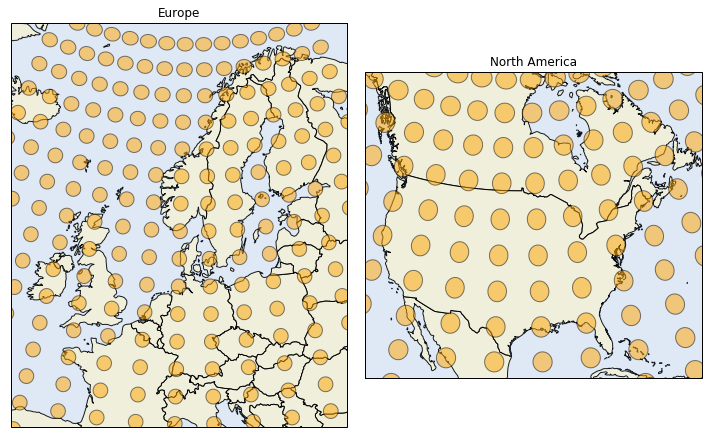

In [11]:
# Define co-ord systems
eu_crs = ccrs.AlbersEqualArea(central_longitude=10, 
                              central_latitude=30, 
                              false_easting=0, 
                              false_northing=0,
                              standard_parallels=(43, 62))

na_crs = ccrs.AlbersEqualArea(central_longitude=-96, 
                              central_latitude=40, 
                              false_easting=0, 
                              false_northing=0,
                              standard_parallels=(20, 60))

crs_dict = {'Europe':[eu_crs,                                # CRS
                      [-1500000, 1250000, 1500000, 4800000], # Bounding box
                      range(-20, 40, 4),                     # Lons for indicatrices
                      range(20, 80, 2),                      # Lats for indicatrices
                      60],                                   # Diameter for indicatrices
            'North America':[na_crs,                                 # CRS
                             [-2500000, 3000000, -2000000, 3000000], # Bounding box
                             range(-180, 60, 8),                     # Lons for indicatrices
                             range(-10, 80, 5),                      # Lats for indicatrices
                             160]}                                   # Diameter for indicatrices 
                             

# Setup plot
fig = plt.figure(figsize=(10,15))

# Love over continents
for idx, cont in enumerate(['Europe', 'North America']):
    # Add subplot
    crs_ax = fig.add_subplot(1,2,idx+1, projection=crs_dict[cont][0])

    # Set extent
    bbox = crs_dict[cont][1]
    crs_ax.set_extent(bbox, crs=crs_dict[cont][0])
                                                     

    # Add Natural Earth data
    # Land
    land_50m = cfeature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_countries', 
                                            scale='50m',
                                            edgecolor='black',
                                            facecolor=cfeature.COLORS['land'])
    crs_ax.add_feature(land_50m)

    # Sea
    sea_50m = cfeature.NaturalEarthFeature(category='physical',
                                           name='ocean',
                                           scale='50m',
                                           edgecolor='none',
                                           facecolor=cfeature.COLORS['water'],
                                           alpha=0.3)
    crs_ax.add_feature(sea_50m)

    # Draw Tissot indicatrices to show distortion
    lons = crs_dict[cont][2]
    lats = crs_dict[cont][3]
    crs_ax.tissot(rad_km=crs_dict[cont][4],     
                  lons=lons, 
                  lats=lats, 
                  n_samples=100,      # Number of points for each circle
                  facecolor='orange',
                  edgecolor='black',
                  alpha=0.5)
    
    # Tidy
    crs_ax.set_title(cont)
    plt.tight_layout()

In [12]:
# Colour boundaries. All define 6 colour classes
col_dict = {'ANC':[-20, 0, 20, 50, 150],        
            'pH':[4.8, 5.2, 5.6, 6.0, 6.4],
            'ANCoaa':[-32, -12, 8, 38, 138],
            'DOC':[6, 12, 18, 24, 30]}

# Loop over datasets
pars = ['pH', 'DOC', 'ANC', 'ANCoaa']
for par in pars:
    for cont in ['Europe', 'North America']:        
        # Get data
        df = wc_df.query('par_name == @par')
    
        # Get unit from first row
        unit = df['unit'].iloc[0]

        # Plot data
        fig = plt.figure(figsize=(10, 10))
    
        # Add subplot
        ax = fig.add_subplot(1, 1, 1, projection=crs_dict[cont][0])
        ax.set_extent(crs_dict[cont][1], crs=crs_dict[cont][0])

        # Add geo data
        ax.add_feature(land_50m)
        ax.add_feature(sea_50m)

        # Create colourmap. Kari's e-mail defines 4 intervals, with one 
        # class above and one below
        if par == 'DOC':
            cmap = plt.get_cmap('jet', 6)                         # Use 'jet' in 6 classes
        else:
            cmap = plt.get_cmap('jet_r', 6)                       # Use 'jet' in 6 classes, reversed
        cmap_list = [cmap(i) for i in range(cmap.N)]              # Get colours explicitly
        cmap = cmap.from_list('Custom cmap', cmap_list[1:-1], 4)  # Use middle 4 colours for Kari's ranges
        cmap.set_under(cmap_list[0])                              # Use first and last colours for
        cmap.set_over(cmap_list[-1])                              # 'under' and 'over'    
        norm = matplotlib.colors.BoundaryNorm(col_dict[par], 4)   # Set class boundaries for 4 'main' colours

        # Plot
        cax = ax.scatter(df['longitude'].values, 
                         df['latitude'].values, 
                         c=df['value'].values, 
                         cmap=cmap,
                         vmin=col_dict[par][0],
                         vmax=col_dict[par][-1], 
                         s=30, 
                         zorder=5,
                         edgecolors='none', 
                         norm=norm,
                         transform=ccrs.PlateCarree(),
                         alpha=0.6)

        # Add colourbar
        cbar = fig.colorbar(cax, shrink=0.65, orientation='horizontal', 
                            pad=0.01, extend='both', aspect=30)

        # Title
        if not unit:
            unit = '-'
        ax.set_title('%s in %s [%s]' % (par, cont, unit), fontsize=20)

        plt.tight_layout()

        # Save
        out_png = (r'../PNGs/raw_points/raw_pts_%s_%s.png' % (par.lower(), 
                                                              cont.replace(' ', '_').lower()))
        plt.savefig(out_png, dpi=300)
        plt.clf()

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

## 5. Export to shapefile

Ultimately, Kari would like the point data overlaying on the acid sensitivity maps in ArcGIS. The easiest way to do this is to export tha data as a shapefile.

In [13]:
# Restructure dataframe
wc_df['unit'].fillna('None', inplace=True)
wc_df['par_unit'] = wc_df['par_name'] + '_' + wc_df['unit']
del wc_df['par_name'], wc_df['unit']

# Unstack
wc_df.set_index(['stn_code', 'longitude', 'latitude', 
                 'country', 'par_unit'], inplace=True)
wc_df = wc_df.unstack(level='par_unit')
wc_df.reset_index(inplace=True)

# Tidy
wc_df.columns = (list(wc_df.columns.get_level_values(0)[:4]) +
                 list(wc_df.columns.get_level_values(1)[4:]))

wc_df.head()

,stn_code,longitude,latitude,country,ALK_ueq/l?,ANC_ueq/l,ANCoaa_ueq/l,DOC_mg C/l,pH_None
0,01ZM,22.028232,54.125488,Poland,NaN,NaN,NaN,NaN,8.00
1,05ZM,23.061399,54.045915,Poland,NaN,5116.8083,NaN,NaN,8.09
2,06ZM,16.497222,53.779722,Poland,NaN,3504.4822,NaN,NaN,8.04
3,06ZM3,16.550713,53.747207,Poland,NaN,170.6033,NaN,NaN,6.51
4,07ZM,18.727878,53.153641,Poland,NaN,4052.2044,NaN,NaN,8.00


In [14]:
# Build gdf
geometry = [Point(xy) for xy in zip(wc_df['longitude'], wc_df['latitude'])]
del wc_df['longitude'], wc_df['latitude']
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(wc_df, crs=crs, geometry=geometry)

# Save as shapefile
out_shp = (r'../Data/GIS/vector/reg_assess_pts.shp')
gdf.to_file(driver='ESRI Shapefile', filename=out_shp)

gdf.head()

,stn_code,country,ALK_ueq/l?,ANC_ueq/l,ANCoaa_ueq/l,DOC_mg C/l,pH_None,geometry
0,01ZM,Poland,NaN,NaN,NaN,NaN,8.00,POINT (22.028232 54.125488)
1,05ZM,Poland,NaN,5116.8083,NaN,NaN,8.09,POINT (23.061399 54.045915)
2,06ZM,Poland,NaN,3504.4822,NaN,NaN,8.04,POINT (16.4972222222222 53.7797222222222)
3,06ZM3,Poland,NaN,170.6033,NaN,NaN,6.51,POINT (16.550713 53.747207)
4,07ZM,Poland,NaN,4052.2044,NaN,NaN,8.00,POINT (18.727878 53.153641)


## 6. Data aggregation

In [15]:
# Define discrete categories
class_dict = {'anc':[wc_df['ANC_ueq/l'].min(), -20, 0, 20, 50, 150, wc_df['ANC_ueq/l'].max()],
              'ancoaa':[wc_df['ANCoaa_ueq/l'].min(), -32, -12, 8, 38, 138, wc_df['ANCoaa_ueq/l'].max()],
              'ph':[wc_df['pH_None'].min(), 4.8, 5.2, 5.6, 6, 6.4, wc_df['pH_None'].max()],
              'doc':[wc_df['DOC_mg C/l'].min(), 6, 12, 18, 24, 30, wc_df['DOC_mg C/l'].max()]}

# Categorise
for par_unit in ['ANC_ueq/l', 'ANCoaa_ueq/l', 'DOC_mg C/l', 'pH_None']:
    # Get par
    par = par_unit.split('_')[0].lower()
    
    # Categorise
    wc_df[par] = pd.cut(wc_df[par_unit], 
                        bins=class_dict[par],
                        labels=range(6))
    
wc_df.head()

,stn_code,country,ALK_ueq/l?,ANC_ueq/l,ANCoaa_ueq/l,DOC_mg C/l,pH_None,geometry,anc,ancoaa,doc,ph
0,01ZM,Poland,NaN,NaN,NaN,NaN,8.00,POINT (22.028232 54.125488),NaN,NaN,NaN,5
1,05ZM,Poland,NaN,5116.8083,NaN,NaN,8.09,POINT (23.061399 54.045915),5.0,NaN,NaN,5
2,06ZM,Poland,NaN,3504.4822,NaN,NaN,8.04,POINT (16.4972222222222 53.7797222222222),5.0,NaN,NaN,5
3,06ZM3,Poland,NaN,170.6033,NaN,NaN,6.51,POINT (16.550713 53.747207),5.0,NaN,NaN,5
4,07ZM,Poland,NaN,4052.2044,NaN,NaN,8.00,POINT (18.727878 53.153641),5.0,NaN,NaN,5


In [16]:
# Restructure and melt
wc_df = wc_df[['country', 'anc', 'ancoaa', 'doc', 'ph']]
wc_df = pd.melt(wc_df, id_vars='country', 
                var_name='par', 
                value_name='class')

# Count number of stations in each category in each country
wc_df.dropna(how='any', inplace=True)
wc_df['class'] = wc_df['class'].astype(int)
wc_df['ones'] = 1
wc_df = wc_df.groupby(['country', 'par', 'class']).agg('count')
wc_df = wc_df.unstack(level=['par', 'class'])

# Rename cols with par name and class ID
wc_df.columns = [i[0] + '_' + str(i[1]) for i in zip(list(wc_df.columns.get_level_values(1)), 
                                                     list(wc_df.columns.get_level_values(2)))]
wc_df.reset_index(inplace=True)

wc_df.head()

,country,anc_0,anc_1,anc_2,anc_3,anc_4,anc_5,ancoaa_0,ancoaa_1,ancoaa_2,...,doc_2,doc_3,doc_4,doc_5,ph_0,ph_1,ph_2,ph_3,ph_4,ph_5
0,Canada,6.0,9.0,84.0,252.0,696.0,534.0,12.0,16.0,106.0,...,122.0,33.0,13.0,19.0,29.0,72.0,123.0,167.0,282.0,908.0
1,Czech Republic,3.0,1.0,1.0,3.0,5.0,6.0,5.0,1.0,2.0,...,NaN,1.0,1.0,NaN,3.0,2.0,5.0,1.0,3.0,6.0
2,Finland,NaN,NaN,4.0,4.0,9.0,1.0,NaN,NaN,3.0,...,2.0,NaN,NaN,NaN,NaN,NaN,4.0,7.0,2.0,5.0
3,Germany,NaN,1.0,NaN,1.0,10.0,7.0,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,2.0,2.0,NaN,1.0,5.0,9.0
4,Ireland,3.0,1.0,2.0,21.0,40.0,25.0,4.0,NaN,8.0,...,4.0,NaN,NaN,NaN,9.0,8.0,8.0,8.0,12.0,47.0


In [17]:
# Create empty dataframe with all combos of par and class
cols = []
for par in ['anc', 'ancoaa', 'ph', 'doc']:
    for cl in range(6):
        cols.append('%s_%s' % (par, cl))
cols = ['country', ] + cols
df = pd.DataFrame(columns=cols)

# Append data and reorder
wc_df = pd.concat([df, wc_df], axis=0)
wc_df = wc_df[cols]

# Fill nan
wc_df.fillna(0, inplace=True)

wc_df.head()

C:\Data\Anaconda2\envs\python_36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  # Remove the CWD from sys.path while we load stuff.


,country,anc_0,anc_1,anc_2,anc_3,anc_4,anc_5,ancoaa_0,ancoaa_1,ancoaa_2,...,ph_2,ph_3,ph_4,ph_5,doc_0,doc_1,doc_2,doc_3,doc_4,doc_5
0,Canada,6.0,9.0,84.0,252.0,696.0,534.0,12.0,16.0,106.0,...,123.0,167.0,282.0,908.0,905.0,489.0,122.0,33.0,13.0,19.0
1,Czech Republic,3.0,1.0,1.0,3.0,5.0,6.0,5.0,1.0,2.0,...,5.0,1.0,3.0,6.0,10.0,8.0,0.0,1.0,1.0,0.0
2,Finland,0.0,0.0,4.0,4.0,9.0,1.0,0.0,0.0,3.0,...,4.0,7.0,2.0,5.0,14.0,2.0,2.0,0.0,0.0,0.0
3,Germany,0.0,1.0,0.0,1.0,10.0,7.0,0.0,0.0,0.0,...,0.0,1.0,5.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0
4,Ireland,3.0,1.0,2.0,21.0,40.0,25.0,4.0,0.0,8.0,...,8.0,8.0,12.0,47.0,47.0,41.0,4.0,0.0,0.0,0.0


In [18]:
# Join to country shapefile
cnt_shp = (r'../Data/GIS/vector/world_countries_dissolve.shp')
countries = gpd.read_file(cnt_shp)

# Get just cols of interest
countries = countries[['geometry', 'NAME']]
countries.columns = ['geometry', 'country']

# Join 
countries = countries.merge(wc_df, on='country')

# Save to shp
out_shp = (r'../Data/GIS/vector/countries_class_counts.shp')
countries.to_file(driver='ESRI Shapefile', filename=out_shp)

countries.head()

,geometry,country,anc_0,anc_1,anc_2,anc_3,anc_4,anc_5,ancoaa_0,ancoaa_1,...,ph_2,ph_3,ph_4,ph_5,doc_0,doc_1,doc_2,doc_3,doc_4,doc_5
0,(POLYGON ((-65.62249147879868 43.3977911469438...,Canada,6.0,9.0,84.0,252.0,696.0,534.0,12.0,16.0,...,123.0,167.0,282.0,908.0,905.0,489.0,122.0,33.0,13.0,19.0
1,"POLYGON ((14.33207023185571 51.04402542113627,...",Czech Republic,3.0,1.0,1.0,3.0,5.0,6.0,5.0,1.0,...,5.0,1.0,3.0,6.0,10.0,8.0,0.0,1.0,1.0,0.0
2,"(POLYGON ((22.4969333407011 59.72087454752236,...",Finland,0.0,0.0,4.0,4.0,9.0,1.0,0.0,0.0,...,4.0,7.0,2.0,5.0,14.0,2.0,2.0,0.0,0.0,0.0
3,"(POLYGON ((8.7021373510579 47.71345126606303, ...",Germany,0.0,1.0,0.0,1.0,10.0,7.0,0.0,0.0,...,0.0,1.0,5.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0
4,(POLYGON ((-9.465273260852314 51.4535950423772...,Ireland,3.0,1.0,2.0,21.0,40.0,25.0,4.0,0.0,...,8.0,8.0,12.0,47.0,47.0,41.0,4.0,0.0,0.0,0.0
